In [2]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Akronim&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Akronim; color:#ff55ee; font-size:35px;'>
    %s</h1>"""%str))
def phtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d-float';      
    </style><h1 class='font-effect-3d-float' 
    style='font-family:Smokum; color:#9955ee; font-size:25px;'>
    %s</h1>"""%str))

In [5]:
dhtml('Code Modules & Functions')

In [4]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,pylab as pl
import pandas as pd,numpy as np,seaborn as sb
import tensorflow.keras.utils as tku
from tensorflow.data import Dataset as tds
import sklearn.model_selection as sms

In [9]:
def pd_style():
    return [dict(selector="th",
                 props=[("font-size","12pt")]),
            dict(selector="td",
                 props=[('padding',"0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size","14pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width','200px'),
                        ('font-size','12pt')])]

In [7]:
dhtml('Data Processing')

In [10]:
url="http://archive.ics.uci.edu/ml/machine-learning-databases"+\
    "/auto-mpg/auto-mpg.data"
dp=tku.get_file("auto-mpg.data",url)
columns=['MPG','Cylinders','Displacement','Horsepower',
         'Weight','Acceleration','ModelYear','Origin']
numeric_columns=columns[2:6]
df=pd.read_csv(dp,names=columns,
               na_values="?",comment='\t',sep=" ",
               skipinitialspace=True)
df.head(10).style.background_gradient('cool', axis=1)\
    .set_properties(**{'max-width':'80px','font-size':'1pt'})\
    .set_caption(phtml("Data Exploration"))\
    .set_precision(2)\
    .set_table_styles(pd_style())

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.00,8,307.00,130.00,3504.00,12.00,70,1
1,15.00,8,350.00,165.00,3693.00,11.50,70,1
2,18.00,8,318.00,150.00,3436.00,11.00,70,1
3,16.00,8,304.00,150.00,3433.00,12.00,70,1
4,17.00,8,302.00,140.00,3449.00,10.50,70,1
5,15.00,8,429.00,198.00,4341.00,10.00,70,1
6,14.00,8,454.00,220.00,4354.00,9.00,70,1
7,14.00,8,440.00,215.00,4312.00,8.50,70,1
8,14.00,8,455.00,225.00,4425.00,10.00,70,1
9,15.00,8,390.00,190.00,3850.00,8.50,70,1


In [11]:
df=df.dropna().reset_index(drop=True)
df.tail(10).style\
.background_gradient(cmap='cool',axis=0,
                     subset=numeric_columns)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
382,26.000000,4,156.000000,92.000000,2585.000000,14.500000,82,1
383,22.000000,6,232.000000,112.000000,2835.000000,14.700000,82,1
384,32.000000,4,144.000000,96.000000,2665.000000,13.900000,82,3
385,36.000000,4,135.000000,84.000000,2370.000000,13.000000,82,1
386,27.000000,4,151.000000,90.000000,2950.000000,17.300000,82,1
387,27.000000,4,140.000000,86.000000,2790.000000,15.600000,82,1
388,44.000000,4,97.000000,52.000000,2130.000000,24.600000,82,2
389,32.000000,4,135.000000,84.000000,2295.000000,11.600000,82,1
390,28.000000,4,120.000000,79.000000,2625.000000,18.600000,82,1
391,31.000000,4,119.000000,82.000000,2720.000000,19.400000,82,1


In [14]:
stats=df.describe().transpose()
dfn=df.copy()
for nc in numeric_columns:
    mean=stats.loc[nc,'mean']
    std=stats.loc[nc,'std']
    dfn.loc[:,nc]=(dfn.loc[:,nc]-mean)/std
dfn.tail(10).style\
.bar(align='mid',color=['#ff55ee','#9955ee'],
     subset=numeric_columns)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
382,26.000000,4,-0.367073,-0.323955,-0.462189,-0.377448,82,1
383,22.000000,6,0.359199,0.195645,-0.167864,-0.304954,82,1
384,32.000000,4,-0.481748,-0.220035,-0.368005,-0.594928,82,3
385,36.000000,4,-0.567753,-0.531795,-0.715308,-0.921150,82,1
386,27.000000,4,-0.414854,-0.375915,-0.032475,0.637463,82,1
387,27.000000,4,-0.519972,-0.479835,-0.220842,0.021267,82,1
388,44.000000,4,-0.930889,-1.363154,-0.997859,3.283479,82,2
389,32.000000,4,-0.567753,-0.531795,-0.803605,-1.428605,82,1
390,28.000000,4,-0.711097,-0.661694,-0.415097,1.108671,82,1
391,31.000000,4,-0.720653,-0.583754,-0.303253,1.398646,82,1


In [15]:
dhtml('TF Data')

In [16]:
numeric_features=[]
for nc in numeric_columns:
    nf=tf.feature_column.numeric_column(key=nc)
    numeric_features.append(nf) 
for nf in numeric_features: 
    phtml(str(nf)); break

In [17]:
fyear=tf.feature_column.numeric_column(key="ModelYear")
fcylinders=tf.feature_column.numeric_column(key="Cylinders")
bucketized_features=[]
fyear=tf.feature_column.bucketized_column(
    source_column=fyear,boundaries=[73,76,79])
fcylinders=tf.feature_column.bucketized_column(
    source_column=fcylinders,boundaries=[4,6,8])
bucketized_features.append(fyear)
bucketized_features.append(fcylinders)
for bf in bucketized_features: 
    phtml(str(bf)); break

In [18]:
forigin=tf.feature_column\
.categorical_column_with_vocabulary_list(
    key='Origin',vocabulary_list=[1,2,3])
categorical_features=\
[tf.feature_column.indicator_column(forigin)]
phtml(str(categorical_features[0]))

In [20]:
features=(numeric_features+
          bucketized_features+ 
          categorical_features)
dfn_train,dfn_test=\
sms.train_test_split(dfn,train_size=.8,shuffle=True)
len(dfn_train),len(dfn_test)

(313, 79)

In [21]:
batch_size=8
def train_input_fn(dfn_train,batch_size):
    dft=dfn_train.copy()
    x_train,y_train=dft,dft.pop('MPG')
    ds_train=tds.from_tensor_slices((dict(x_train),y_train))
    return ds_train.shuffle(1000).repeat().batch(batch_size)
ds_train=train_input_fn(dfn_train,batch_size)
batch=next(iter(ds_train))
phtml('keys: </br>%s'%batch[0].keys())
phtml('batch values of `Cylinders`: </br> %s'%batch[0]['Cylinders'])

In [23]:
def test_input_fn(dfn_test,batch_size):
    dft2=dfn_test.copy()
    x_test,y_test=dft2,dft2.pop('MPG')
    ds_test=tds.from_tensor_slices((dict(x_test),y_test))
    return ds_test.batch(batch_size)
ds_test=train_input_fn(dfn_test,batch_size)
batch=next(iter(ds_test))
phtml('keys: </br>%s'%batch[0].keys())
phtml('batch values of `ModelYear`: </br>%s'%\
      batch[0]['ModelYear'])

In [22]:
dhtml('TF Regressor')

In [24]:
reg=tf.estimator.DNNRegressor(
    feature_columns=features,hidden_units=[32,10],
    model_dir='models/autompg-dnnregressor/');

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [25]:
epochs=1000
steps=epochs*int(np.ceil(len(dfn_train)/batch_size))
phtml('training steps: %d'%steps)
reg.train(input_fn=lambda:\
          train_input_fn(dfn_train,
          batch_size),steps=steps);

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
IN

In [26]:
reloaded_reg=tf.estimator.DNNRegressor(
    feature_columns=features,hidden_units=[32,10],
    warm_start_from='models/autompg-dnnregressor/',
    model_dir='models/autompg-dnnregressor/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [27]:
test_results=reloaded_reg\
.evaluate(input_fn=lambda:\
          test_input_fn(dfn_test,batch_size))
for key in test_results:
    phtml('{}: {}'.format(key,test_results[key]))
phtml('test average loss% {:.4f}'\
      .format(test_results['average_loss']))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-20T16:37:21Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.33614s
INFO:tensorflow:Finished evaluation at 2020-08-20-16:37:21
INFO:tensorflow:Saving dict for global step 40000: average_loss = 1

In [28]:
y_test_pred=reg.predict(input_fn=lambda:\
                        test_input_fn(dfn_test,batch_size))
py_test=[]
for i in range(len(dfn_test)):
    py_test.append(next(iter(y_test_pred))['predictions'][0])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


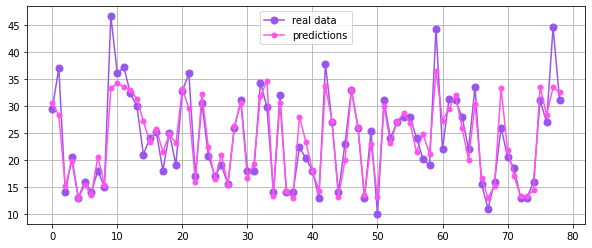

In [29]:
pl.figure(figsize=(10,4))
pl.plot(range(len(dfn_test)),dfn_test['MPG'],
        '-o',label='real data',c='#9955ee',ms=7)
pl.plot(range(len(dfn_test)),py_test,
        '-o',label='predictions',c='#ff55ee',ms=5)
pl.grid(); pl.legend();